In [1]:
import pandas as pd
import numpy as np

In [2]:
def get_Cushing_painted_properties(path_to_PI_data):
    # Read data
    df = pd.read_pickle(path_to_PI_data)
    df.index = df.index.tz_convert('MST').tz_localize(None)
    df = df.bfill()

    # Get density
    pi_tag_list = [
                    'CSHTT-B0-MOV7408',
                    'CSHNG-B0-MOV2408',
                    'CSHTT-B0-MOV7410',
                    'CSHSP-B0-MOV0100',
                    'CSHSP-B0-RTP-MOVBP',
                    'CSHSP-B0-RTP-MOVIN',
                    'CSHSP-B0-RTP-MOVKCK',
                    'CSHSP-B0-Q',
                    'CSHTT-B0-MB11-Q',
                    'CSHTT-B0-MB12-Q',
                    'CSHTT-B0-QMU11-DEN',
                    'CSHTT-B0-QMU12-DEN',
                    'CSHSP-B0-DEN',
                    'CSHTT-B0-QMU11-T',
                    'CSHTT-B0-QMU12-T',
                    'CSHSP-B0-TS',
                    'CSHTT-B0-QMU11-VISCLN',
                    'CSHTT-B0-QMU12-VISCLN']

    tag_not_found_list = []
    for tag in pi_tag_list:
        if tag not in df.columns:
            tag_not_found_list.append(tag)
        else:
            pass
    if tag_not_found_list != []:
        raise ValueError('These tags are not found in the data set:\n' + '\n'.join(tag_not_found_list))
    else:
        pass

    df_result = pd.DataFrame(df.loc[:,['CSHSP-B0-Q','CSHSP-B0-TS', 'CSHSP-B0-DEN']])
    df_result = df_result.rename(columns={'CSHSP-B0-Q':'Q', 'CSHSP-B0-TS': 'Ts', 'CSHSP-B0-DEN':'rho'})
    
    open_status = 1
    
    df_result['MB11_openpath'] = df_result['Q'] * 0
    idx = df[(df['CSHTT-B0-MOV7408']==open_status) &  (df['CSHNG-B0-MOV2408']==open_status)].index
    if len(idx)>0:
        df_result.loc[idx, 'MB11_openpath'] = 1
        
    df_result['MB12_openpath'] = df_result['Q'] * 0
    idx = df[(df['CSHTT-B0-MOV7410']==open_status) &  (df['CSHNG-B0-MOV2408']==open_status)].index
    if len(idx)>0:
        df_result.loc[idx,'MB12_openpath'] = 1
        
    df_result['tightline_openpath'] = df['HRDSY-A0-Q'] * 0
    idx = df[(df['CSHSP-B0-MOV0100']==open_status) & ((df['CSHSP-B0-RTP-MOVBP']==open_status) | ((df['CSHSP-B0-RTP-MOVIN']==open_status) & (df['CSHSP-B0-RTP-MOVKCK']==open_status)))].index
    if len(idx)>0:
        df_result.loc[idx, 'tightline_openpath'] = 1

    df_result['TNK_openpath'] = df_result['Q'] * 0
    idx = df[(('CSHNG-B0-MOV2408'==open_status) & 
              ((df['CSHSP-B0-Q'] - df['CSHTT-B0-MB11-Q'] - df['CSHTT-B0-MB12-Q']) >100) & (df_result['tightline_openpath']==0))].index
    if len(idx)>0:
        df_result.loc[idx, 'TNK_openpath'] = 1
    
    df_result['MB11_Q'] = df_result['Q'] * 0
    df_result.loc[df_result['MB11_openpath']==1, 'MB11_Q'] = df.loc[df_result['MB11_openpath']==1, 'CSHTT-B0-MB11-Q']
    df_result['MB12_Q'] = df_result['Q'] * 0
    df_result.loc[df_result['MB12_openpath']==1, 'MB12_Q'] = df.loc[df_result['MB12_openpath']==1, 'CSHTT-B0-MB12-Q']
    df_result['tightline_Q'] =  df_result['Q'] * 0
    df_result.loc[df_result['tightline_openpath']==1, 'tightline_Q'] = df.loc[df_result['tightline_openpath']==1, 'CSHSP-B0-Q']
    df_result['TNK_Q'] =  df_result['Q'] * 0
    df_result.loc[df_result['TNK_openpath']==1, 'TNK_Q'] = df.loc[df_result['TNK_openpath']==1, 'CSHSP-B0-Q']
    
    df_result['TNK_VISC'] = df_result['Q'] * 0
    df_result.loc[df['CSHSP-B0-DEN']>870, 'TNK_VISC'] = 300
    df_result.loc[df['CSHSP-B0-DEN']<=870, 'TNK_VISC'] = 150

    if any(df_result['tightline_openpath'] != 0):
        raise(ValueError('Current approach does not account for tightline operation. Please modify this script by reading results from upstream advection simulation for tightline case.'))
    else:
        pass
        
    df_result['rho_painted']  = (df['CSHTT-B0-QMU11-DEN'] * df_result['MB11_Q'] + df['CSHTT-B0-QMU12-DEN'] * df_result['MB12_Q'] +df['CSHSP-B0-DEN'] * df_result['TNK_Q']) / (df_result['MB11_Q'] + df_result['MB12_Q'] + df_result['TNK_Q'])
    df_result['mu_painted']   = (df['CSHTT-B0-QMU11-VISCLN'] * df_result['MB11_Q'] + df['CSHTT-B0-QMU12-VISCLN'] * df_result['MB12_Q'] +df_result['TNK_VISC'] * df_result['TNK_Q']) / (df_result['MB11_Q'] + df_result['MB12_Q'] + df_result['TNK_Q'])

    df_result['Tref_painted'] = (df['CSHTT-B0-QMU11-T'] * df_result['MB11_Q'] + df['CSHTT-B0-QMU12-T'] * df_result['MB12_Q'] + df_result['Ts'] * df_result['TNK_Q']) / (df_result['MB11_Q'] + df_result['MB12_Q'] + df_result['TNK_Q'])

    df_result['mu_filtered']   = df_result['mu_painted'].copy()
    idx_mu_out_of_range = df_result[df_result['mu_painted']>500].index
    df_result.loc[idx_mu_out_of_range, 'mu_filtered'] = ASTM_viscosity(6.72, 2.58, df_result.loc[idx_mu_out_of_range, 'Tref_painted'])
    #
    #df_result['mu_normalized'] = ASTM_viscosity(ASTM_a(df_result['mu_filtered'], 2.58, df_result['Tref_painted']), 2.58, df_result['Tref_painted'])
    return(df_result)

def ASTM_viscosity(A, B, T):
    return(10**(10**(A - B * np.log10(T+273.15))))
    
def ASTM_a(mu, B, T):
    return(np.log10(np.log10(mu)) + B * np.log10(T+273.15))

In [3]:
df_CSHNG = get_Cushing_painted_properties('../data/PI_data_for_linefill_all.pkl')

In [4]:
df_CSHNG['ASTM_A'] = np.log10(np.log10(df_CSHNG['mu_painted'])) + 2.58 * np.log10(df_CSHNG['Tref_painted']+273.15)

C:\Users\Zixiang.Chen\python_environments\LDE\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Zixiang.Chen\python_environments\LDE\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


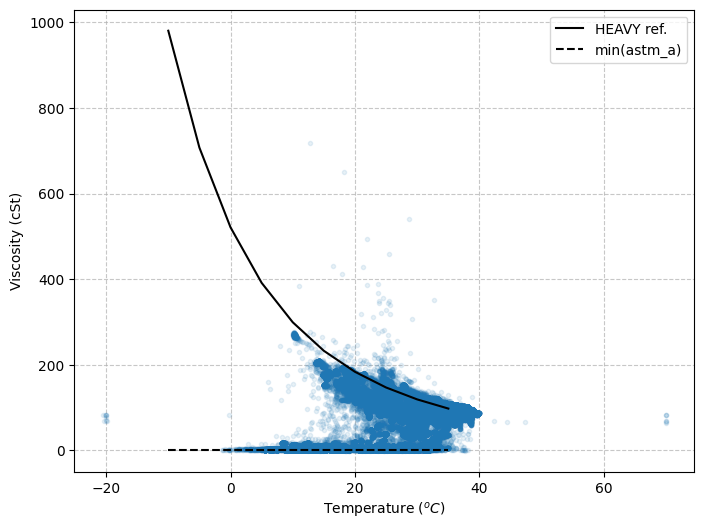

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
idx = df_CSHNG[df_CSHNG['Q']>100].index
x = df_CSHNG.loc[idx, 'Tref_painted'].values
y = df_CSHNG.loc[idx, 'mu_painted'].values
# Create the scatter plot
plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(x, y, '.', alpha=0.1)  # Create scatter plot

# astm lines
A = 6.72
B = 2.58
x = np.arange(-10, 40, 5)
y = 10**(10**(A - B * np.log10(x+273.15)))
plt.plot(x, y, 'k', label='HEAVY ref.')

# 
A = df_CSHNG['ASTM_A'].min()
B = 2.58
x = np.arange(-10, 40, 5)
y = 10**(10**(A - B * np.log10(x+273.15)))
plt.plot(x, y, 'k--', label='min(astm_a)')
# 
A = df_CSHNG['ASTM_A'].max()
B = 2.58
x = np.arange(-10, 40, 5)
y = 10**(10**(A - B * np.log10(x+273.15)))
#plt.plot(x, y, 'k-.', label='max(astm_a)')
    
# Add labels and title
plt.xlabel('Temperature ($^oC$)')
plt.ylabel('Viscosity (cSt)')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
# Show the plot
plt.show()

In [6]:
df_CSHNG['ASTM_A'] = np.log10(np.log10(df_CSHNG['mu_filtered'])) + 2.58 * np.log10(df_CSHNG['Tref_painted']+273.15)

C:\Users\Zixiang.Chen\python_environments\LDE\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Zixiang.Chen\python_environments\LDE\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


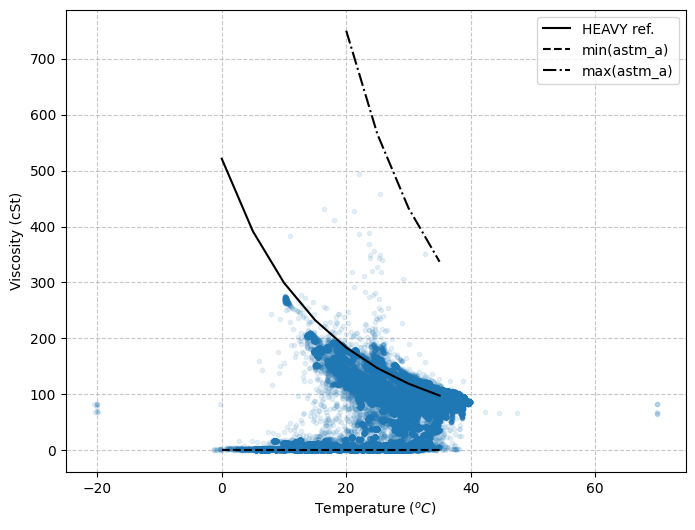

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
idx = df_CSHNG[df_CSHNG['Q']>100].index
x = df_CSHNG.loc[idx, 'Tref_painted'].values
y = df_CSHNG.loc[idx, 'mu_filtered'].values
# Create the scatter plot
plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(x, y, '.', alpha=0.1)  # Create scatter plot

# astm lines
A = 6.72
B = 2.58
x = np.arange(0, 40, 5)
y = 10**(10**(A - B * np.log10(x+273.15)))
plt.plot(x, y, 'k', label='HEAVY ref.')

# 
A = df_CSHNG['ASTM_A'].min()
B = 2.58
x = np.arange(0, 40, 5)
y = 10**(10**(A - B * np.log10(x+273.15)))
plt.plot(x, y, 'k--', label='min(astm_a)')
# 
A = df_CSHNG['ASTM_A'].max()
B = 2.58
x = np.arange(20, 40, 5)
y = 10**(10**(A - B * np.log10(x+273.15)))
plt.plot(x, y, 'k-.', label='max(astm_a)')
    
# Add labels and title
plt.xlabel('Temperature ($^oC$)')
plt.ylabel('Viscosity (cSt)')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
# Show the plot
plt.show()

In [8]:
df_CSHNG.to_pickle('../output/df_CSHNG.pkl')